In [68]:
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import cross_val_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10




In [69]:
data=pd.read_csv('dataCompletAvrilto18Juin.csv', sep=";", encoding = "ISO-8859-1")
data1 = pd.read_csv('./dataImputed/KNN10.csv',sep=",", encoding = "ISO-8859-1")
#Linky=pd.read_csv('Enedis_Conso_Heure_20210325-20210427_09311432680380.csv', sep=";", encoding = "ISO-8859-1")

In [70]:
data1.head(2)

,time,Temperature,Humidity,CO2,Noise,Pressure
0,1617235589,0.293575,0.369908,-0.071631,-0.531945,0.195873
1,1617235891,0.293575,0.369908,-0.272994,-0.531945,0.195873


In [71]:
ff,a=lagged(data1,5)

In [72]:
len(a)

5

In [75]:
def lagged(df,lag=2):
    #df=df.set_index('time')    
    Df=[]
    a=[]
    for i in range(lag):
        a.append(i)
        df1=df.shift(i+1).copy()
        df1=df1.add_suffix('_t-'+str(i+1))
        Df.append(df1)
    for base in Df:
        df=pd.concat([df,base], axis=1)
    
    df=df.drop(df.index[a])
    return df, a 

In [76]:
# Création de jour de semaine (d.isoweekday()) et l'heure de la journée (d.hour+d.minute/60) à partire de timestamp
import datetime
Jsemaine =[]
heure=[]
for t in data.time:
    d=datetime.datetime.fromtimestamp(t)
    Jsemaine.append(d.isoweekday())
    heure.append(d.hour+d.minute/60)

In [77]:
a

[0, 1, 2, 3, 4]

In [105]:
RANDOM_SEED = 20
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

test_size=0.20
lagg=3
#nbObservation=14400
nbObservation=14400
scaler = StandardScaler()
datascaler=scaler.fit(data.values[:,1:-1])

# list = os.listdir('dataImputed')
# for fichier in list:
directory = 'dataImputed'
lagg=3
# iterate over files in
# that directory
i=1
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        df = pd.read_csv(f, sep=",", encoding = "ISO-8859-1")        
        df= pd.DataFrame(datascaler.inverse_transform(df.values[:,1:]),columns=df.columns[1:])
        #print(df.head(2))
        df, lignesAsupprimer=lagged(df,lagg)
        data1=data.copy()
        df["activity"] = data1.activity.drop(data1.index[lignesAsupprimer]) # supprimer les lignes 0,1
        df['activity'].replace(['Absent','Present'],[0,1], inplace=True)
        df["JourSemaine"]=Jsemaine[len(lignesAsupprimer):]
        df["heureday"]=heure[len(lignesAsupprimer):]
        #print(df.columns)
        db2=df.copy()      
        X=db2.copy()       
        X=X.drop('activity', axis=1)
        y=db2['activity']
        X_train,X_test,y_train,y_test=train_test_split(X[0:nbObservation],y[0:nbObservation],test_size=test_size,shuffle=False)       
         
        rf_model=RandomForestClassifier(max_features='log2', n_estimators= 300, max_depth=None, criterion='entropy')
        rf_model.fit(X_train,y_train)       

        y_true = y_test
        y_pred = rf_model.predict(X_test)
        f1macro=f1_score(y_true, y_pred, average='macro')
        f1micro=f1_score(y_true, y_pred, average='micro')
        f1weighted=f1_score(y_true, y_pred, average='weighted')
        print(filename,";",rf_model.score(X_test,y_test),";",f1weighted)
        i=i+1       

       
    

Back_fill10.csv ; 0.9072916666666667 ; 0.8925018365957349
Back_fill25.csv ; 0.9131944444444444 ; 0.897025324514386
Back_fill40.csv ; 0.9145833333333333 ; 0.8995671613394216
Back_fill5.csv ; 0.9142361111111111 ; 0.902939524155208
Forward_fill10.csv ; 0.9076388888888889 ; 0.8911632641910275
Forward_fill25.csv ; 0.9111111111111111 ; 0.8947895980221405
Forward_fill40.csv ; 0.915625 ; 0.897682893510334
Forward_fill5.csv ; 0.9086805555555556 ; 0.8952011748009749
kalmanArima_TRUE_MCAR10.csv ; 0.9097222222222222 ; 0.8973281404361552
kalmanArima_TRUE_MCAR25.csv ; 0.9114583333333334 ; 0.8966782431269796
kalmanArima_TRUE_MCAR40.csv ; 0.9166666666666666 ; 0.9015842839036755
kalmanArima_TRUE_MCAR5.csv ; 0.9111111111111111 ; 0.8968221587560632
kalmanStructTS_TRUE_MCAR10.csv ; 0.9114583333333334 ; 0.897547897505918
kalmanStructTS_TRUE_MCAR25.csv ; 0.9090277777777778 ; 0.8944039281019084
kalmanStructTS_TRUE_MCAR40.csv ; 0.9180555555555555 ; 0.9050824479573047
kalmanStructTS_TRUE_MCAR5.csv ; 0.90694444

In [261]:
moyennes1=[]
moyennes2=[]
for i in range(len(Performances)):
    moyennes1.append(statistics.mean(Performances[i][0]))
    moyennes2.append(statistics.mean(Performances[i][1]))
print(moyennes1)
print(moyennes2)

[0.9157819836360548, 0.9080743944494355, 0.9229011050221072, 0.9181286595522762, 0.9068384774735119, 0.9032165812860011, 0.9243357389415139, 0.9152564149302276]
[0.9093663447145335, 0.9072031971212425, 0.9238748401642103, 0.9007657614309561, 0.9041467399473211, 0.909785569355632, 0.9143233598908493, 0.9059484532425146]


In [265]:
moyennes2

[0.9093663447145335,
 0.9072031971212425,
 0.9238748401642103,
 0.9007657614309561,
 0.9041467399473211,
 0.909785569355632,
 0.9143233598908493,
 0.9059484532425146]

In [266]:
fichiers

['kalmanArima_TRUE_MCAR10.csv',
 'kalmanArima_TRUE_MCAR25.csv',
 'kalmanArima_TRUE_MCAR40.csv',
 'kalmanArima_TRUE_MCAR5.csv',
 'kalmanStructTS_TRUE_MCAR10.csv',
 'kalmanStructTS_TRUE_MCAR25.csv',
 'kalmanStructTS_TRUE_MCAR40.csv',
 'kalmanStructTS_TRUE_MCAR5.csv']

In [ ]:
df=data.copy()
df=lagged(df)
df['activity'].replace(['Absent','Present'],[0,1], inplace=True)
df["JourSemaine"]=Jsemaine
df["heureday"]=heure
db2=df.copy()
#X=db2.drop('time', axis=1).copy()
X=db2.copy()
X=X.drop('time', axis=1).copy()
X=X.drop('activity', axis=1)
y=db2['activity']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,shuffle=False)
# importation de la bibiothèque RandomForestClassifier   
rf_model=RandomForestClassifier(max_features='log2', n_estimators= 300, max_depth=5, criterion='entropy')
rf_model.fit(X_train,y_train)   
    
y_true = y_test
y_pred = rf_model.predict(X_test)
f1macro=f1_score(y_true, y_pred, average='macro')
f1micro=f1_score(y_true, y_pred, average='micro')
f1weighted=f1_score(y_true, y_pred, average='weighted')
print("CompletData",";",rf_model.score(X_test,y_test),";",f1weighted) 

In [10]:
RANDOM_SEED = 2
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

test_size=0.20
lagg=2
scaler = StandardScaler()
datascaler=scaler.fit(data.values[:,1:-1])

list = os.listdir('dataImputed')
for fichier in list:   
    print(fichier)

Back_fill10.csv
Back_fill25.csv
Back_fill40.csv
Back_fill5.csv
dataComplet.csv
Forward_fill10.csv
Forward_fill25.csv
Forward_fill40.csv
Forward_fill5.csv
kalmanArima_TRUE_MCAR10.csv
kalmanArima_TRUE_MCAR25.csv
kalmanArima_TRUE_MCAR40.csv
kalmanArima_TRUE_MCAR5.csv
kalmanStructTS_TRUE_MCAR10.csv
kalmanStructTS_TRUE_MCAR25.csv
kalmanStructTS_TRUE_MCAR40.csv
kalmanStructTS_TRUE_MCAR5.csv
KNN10.csv
KNN25.csv
KNN40.csv
KNN5.csv
Linear_Interpolation10.csv
Linear_Interpolation25.csv
Linear_Interpolation40.csv
Linear_Interpolation5.csv
Nearest_imput10.csv
Nearest_imput25.csv
Nearest_imput40.csv
Nearest_imput5.csv
polynomial_interpolation10.csv
polynomial_interpolation25.csv
polynomial_interpolation40.csv
polynomial_interpolation5.csv
Quadratic_Interpolation10.csv
Quadratic_Interpolation25.csv
Quadratic_Interpolation40.csv
Quadratic_Interpolation5.csv


In [5]:
# afficher l’importance des variables de notre modèle de forêt aléatoire
pd.DataFrame(rf_model.feature_importances_,
              index = X_train.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
CO2,0.439435
heureday,0.172507
Temperature,0.147393
Pressure,0.072803
Humidity,0.069209
Noise,0.049946
JourSemaine,0.048706


# RandomForestClassifier

In [134]:
# importation de la bibiothèque RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# construire un model random forest
# Instanciation du modèle
rf_model=RandomForestClassifier(max_features='log2', n_estimators= 300, max_depth=500, criterion='entropy') 
# entrainement du model
rf_model.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=500, max_features='log2',
                       n_estimators=300)

In [136]:
# afficher le score du modele sur les données de test
rf_model.score(X_test,y_test)

0.9757288737605446

In [185]:
# afficher l’importance des variables de notre modèle de forêt aléatoire
pd.DataFrame(rf_model.feature_importances_,
              index = X_train.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
CO2_lag1,0.199460
CO2_lag2,0.189422
CO2,0.143372
heureday,0.120151
Temperature_lag1,0.088724
Temperature_lag2,0.054696
Temperature,0.038260
Pressure_lag1,0.022027
Pressure_lag2,0.021776
Pressure,0.021738


In [ ]:
Jsemaine

# Matrice de confusion

In [138]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, rf_model.predict(X_test)),
             index = ["Present_data", "Abscent_data"],
             columns = ["Present_predit", "Abscent_predit"])

,Present_predit,Abscent_predit
Present_data,2335,123
Abscent_data,41,4258


In [139]:
from sklearn import metrics

y_pred = rf_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.98274411, 0.97192422]),
 array([0.94995932, 0.9904629 ]),
 array([0.96607365, 0.98110599]),
 array([2458, 4299], dtype=int64))

In [140]:
#db2['Activity_Pred']=model.predict(X)

In [147]:
## SVM

In [148]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svc_model = make_pipeline(StandardScaler(), SVC(C=10, gamma=1))
svc_model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma=1))])

In [149]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc=scaler.fit_transform(X_train)

In [150]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, svc_model.predict(X_test)),
             index = ["Present_data", "Abscent_data"],
             columns = ["Present_predit", "Abscent_predit"])

,Present_predit,Abscent_predit
Present_data,2253,205
Abscent_data,113,4186


In [151]:
from sklearn import metrics

y_pred = svc_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.95224007, 0.9533136 ]),
 array([0.91659886, 0.97371482]),
 array([0.9340796 , 0.96340621]),
 array([2458, 4299], dtype=int64))

# KNN

In [152]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model=KNeighborsClassifier(n_neighbors=1,metric='manhattan')
KNN_model.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [153]:
KNN_model.score(X_test,y_test)

0.9711410389225987

In [154]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, KNN_model.predict(X_test)),
             index = ["Present_data", "Abscent_data"],
             columns = ["Present_predit", "Abscent_predit"])

,Present_predit,Abscent_predit
Present_data,2350,108
Abscent_data,87,4212


In [155]:
from sklearn import metrics

y_pred = KNN_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.96430037, 0.975     ]),
 array([0.95606184, 0.97976274]),
 array([0.96016343, 0.97737557]),
 array([2458, 4299], dtype=int64))

In [147]:
from datetime import datetime 

In [148]:
d1 = datetime.now()

In [131]:
d1.hour+d1.minute/60

10.6

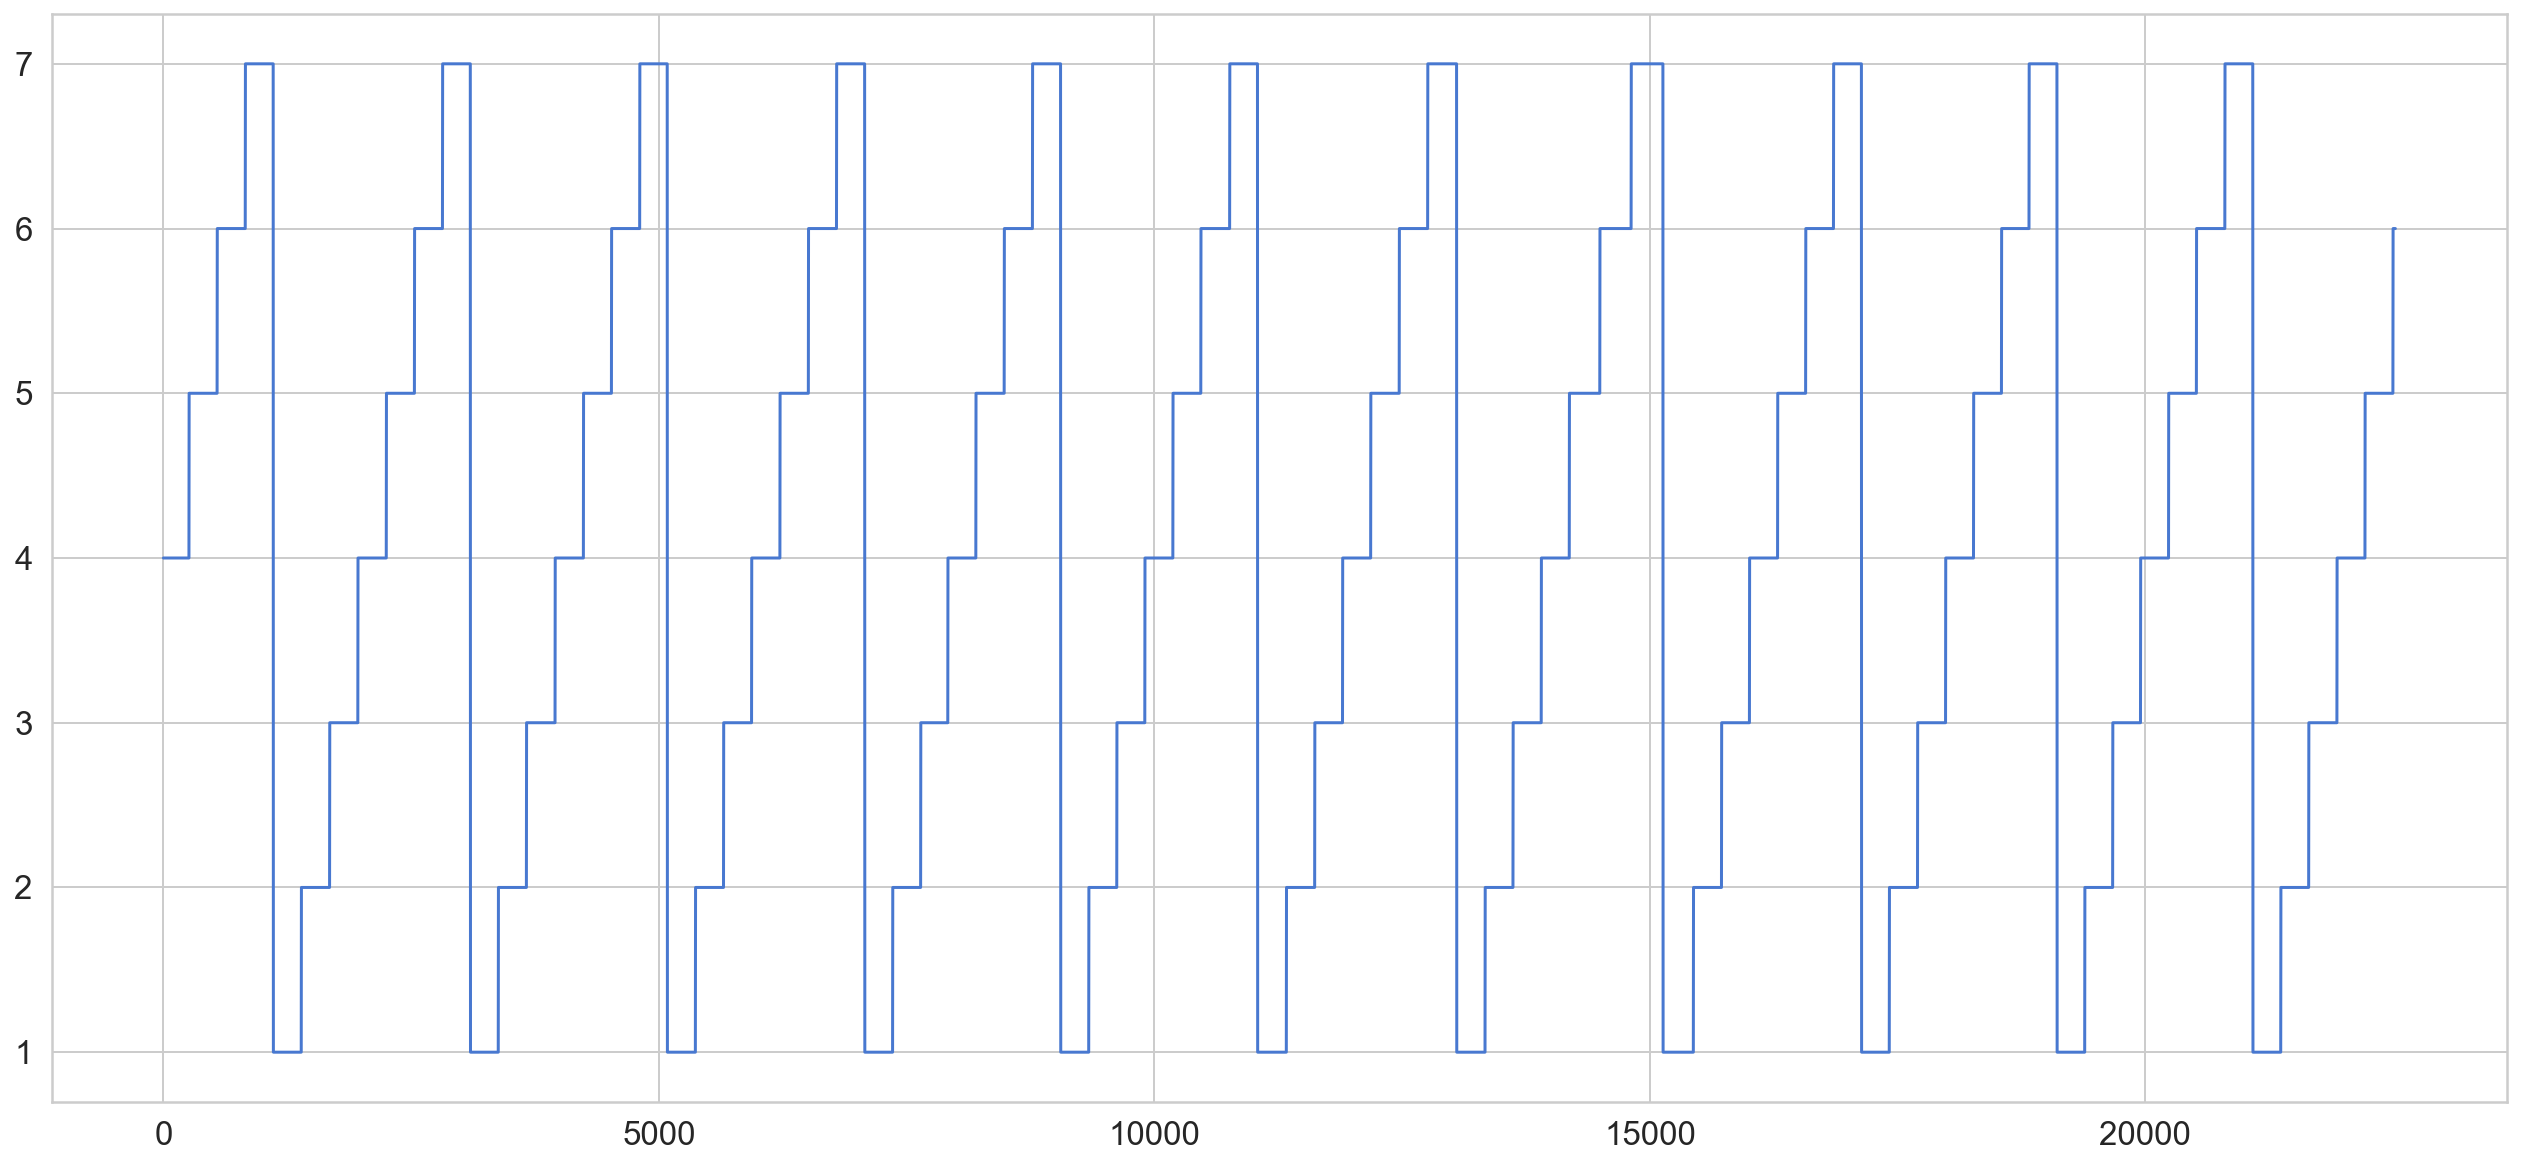

In [174]:
plt.plot(Jsemaine)


In [158]:
    
   
####
# df=data.copy()
# df['activity'].replace(['Absent','Present'],[0,1], inplace=True)
# df["JourSemaine"]=Jsemaine
# df["heureday"]=heure
# db2=df.copy()
# #X=db2.drop('time', axis=1).copy()
# X=db2.copy()
# X=X.drop('time', axis=1).copy()
# X=X.drop('activity', axis=1)
# y=db2['activity']
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,shuffle=False)
# # importation de la bibiothèque RandomForestClassifier   
# rf_model=RandomForestClassifier(max_features='log2', n_estimators= 300, max_depth=5, criterion='entropy')
# rf_model.fit(X_train,y_train)   
    
# y_true = y_test
# y_pred = rf_model.predict(X_test)
# f1macro=f1_score(y_true, y_pred, average='macro')
# f1micro=f1_score(y_true, y_pred, average='micro')
# f1weighted=f1_score(y_true, y_pred, average='weighted')
# print("CompletData",";",rf_model.score(X_test,y_test),";",f1weighted) 

22523

In [142]:
df = pd.read_csv("./dataImputed/A_dataComplet.csv", sep=",", encoding = "ISO-8859-1")  

In [167]:
#df = pd.read_csv(f, sep=",", encoding = "ISO-8859-1")
a=[]
import random
for i in range(1,100):
    random.seed(i)
    df=df2.copy()
    df= pd.DataFrame(datascaler.inverse_transform(df.values[:,1:]),columns=df.columns[1:])
    #print(df.head(2))
    df=lagged(df)
    data1=data.copy()
    df["activity"] = data1.activity.drop(data1.index[[0,1]]) # supprimer les lignes 0,1
    df['activity'].replace(['Absent','Present'],[0,1], inplace=True)
    df["JourSemaine"]=Jsemaine[lagg:]
    df["heureday"]=heure[lagg:]
    db2=df.copy()      
    X=db2.copy()
    X=X.drop('activity', axis=1)
    y=db2['activity']
    X_train,X_test,y_train,y_test=train_test_split(X[0:14400],y[0:14400],test_size=test_size,shuffle=False)       

    rf_model=RandomForestClassifier(max_features='log2', n_estimators= 100, max_depth=5, criterion='entropy')
    rf_model.fit(X_train,y_train)   

    y_true = y_test
    y_pred = rf_model.predict(X_test)
    f1weighted=f1_score(y_true, y_pred, average='weighted')
    #print(filename,";",rf_model.score(X_test,y_test),";",f1weighted)
    a.append(f1weighted)
    

In [169]:
a
A_rank = a
import statistics
statistics.stdev(A_rank)

0.003107765286416552

In [170]:
statistics.mean(A_rank)

0.9087912040180062

In [ ]:
0.9229166666666667 ; 0.9079346254630883
0.9229166666666667 ; 0.908352342299261

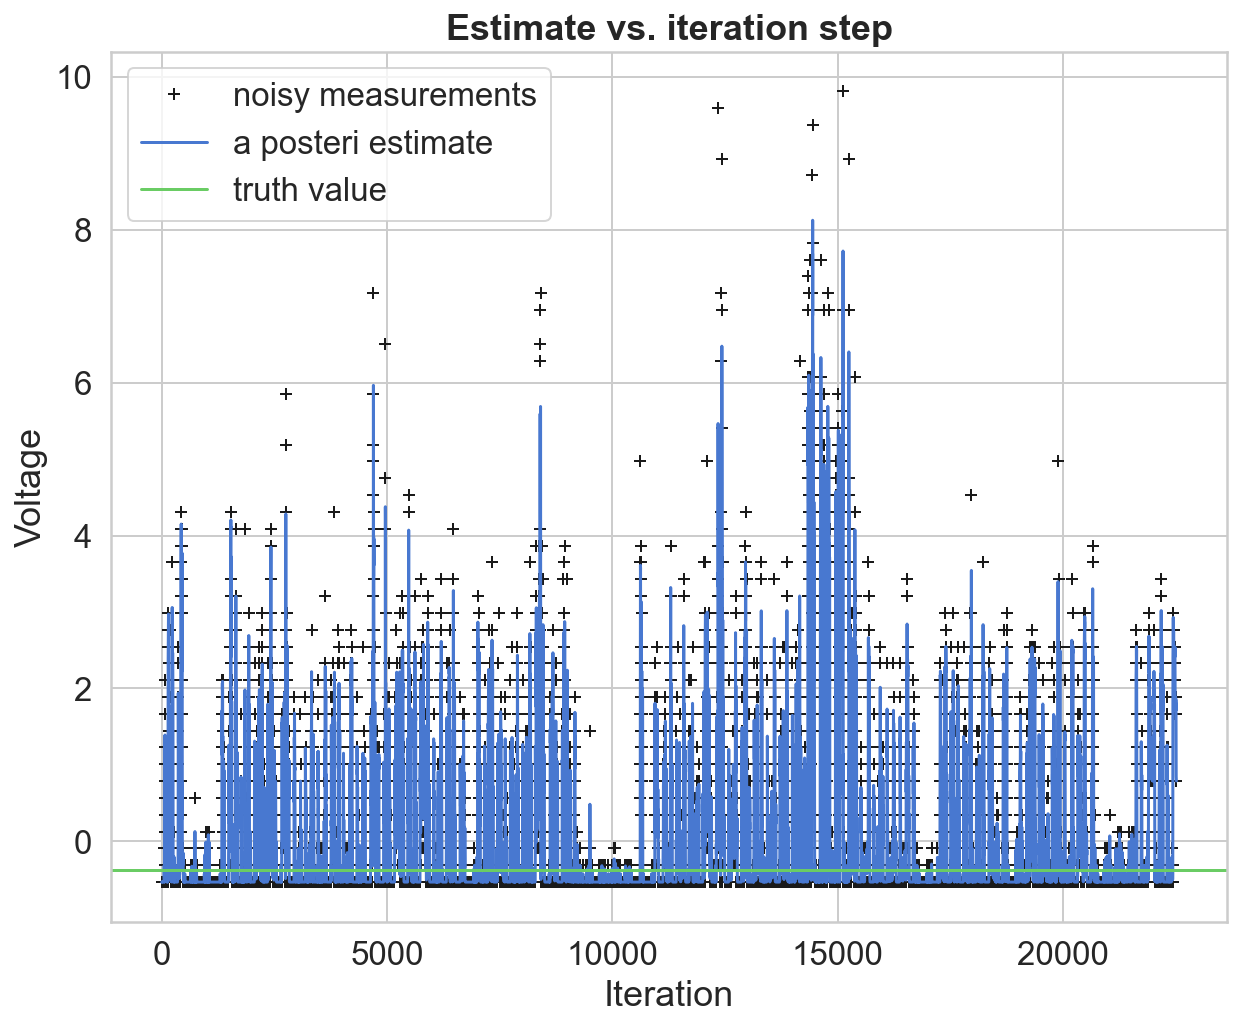

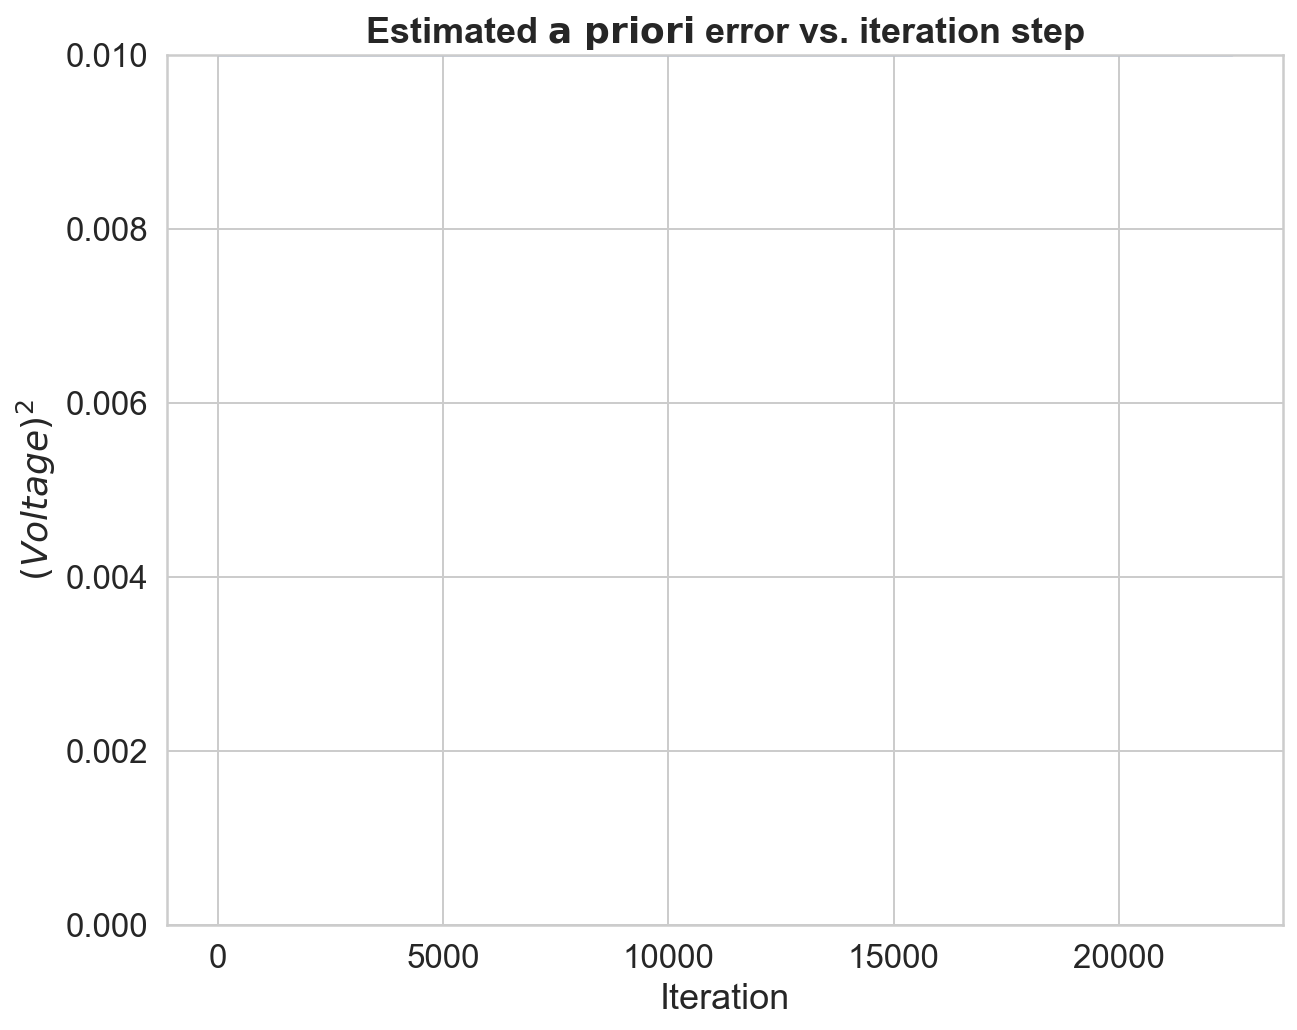

In [156]:
# Kalman filter example demo in Python

# A Python implementation of the example given in pages 11-15 of "An
# Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
# University of North Carolina at Chapel Hill, Department of Computer
# Science, TR 95-041,
# https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

# by Andrew D. Straw

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

# intial parameters
n_iter = data.Temperature.shape[0]
sz = (n_iter,) # size of array
x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
z = df.Noise # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance
Q = 0.005

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

plt.figure()
plt.plot(z,'k+',label='noisy measurements')
xhat[0]= z[0]
plt.plot(xhat,'b-',label='a posteri estimate')
plt.axhline(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01])
plt.show()


In [157]:
df.Noise=xhat

In [158]:
df2=df.copy() 

In [ ]:
A_dataComplet.csv ; 0.9208333333333333 ; 0.90608709595712
Back_fill10.csv ; 0.91875 ; 0.9068516298304142
Back_fill25.csv ; 0.9083333333333333 ; 0.8957485733659422
Back_fill40.csv ; 0.921875 ; 0.9074265801917718
Back_fill5.csv ; 0.9211805555555556 ; 0.9102706727878886
Forward_fill10.csv ; 0.9048611111111111 ; 0.8917996556904095
Forward_fill25.csv ; 0.9020833333333333 ; 0.888860047591996
Forward_fill40.csv ; 0.921875 ; 0.9082409727652119
Forward_fill5.csv ; 0.9145833333333333 ; 0.8975105572643809
kalmanArima_TRUE_MCAR10.csv ; 0.9173611111111111 ; 0.9042780619230448
kalmanArima_TRUE_MCAR25.csv ; 0.9145833333333333 ; 0.9020747903345381
kalmanArima_TRUE_MCAR40.csv ; 0.9170138888888889 ; 0.9076727247229454
kalmanArima_TRUE_MCAR5.csv ; 0.915625 ; 0.9050630306178021
kalmanStructTS_TRUE_MCAR10.csv ; 0.9138888888888889 ; 0.9030166973204948
kalmanStructTS_TRUE_MCAR25.csv ; 0.9114583333333334 ; 0.9014918192650673
kalmanStructTS_TRUE_MCAR40.csv ; 0.9149305555555556 ; 0.9023737179704899
kalmanStructTS_TRUE_MCAR5.csv ; 0.9114583333333334 ; 0.8994020547635068
KNN10.csv ; 0.9090277777777778 ; 0.8979320556815759
KNN25.csv ; 0.9024305555555555 ; 0.8887039332582991
KNN40.csv ; 0.9194444444444444 ; 0.9082030307504062
KNN5.csv ; 0.9149305555555556 ; 0.9023737179704899
Linear_Interpolation10.csv ; 0.91875 ; 0.9046744546974185
Linear_Interpolation25.csv ; 0.9170138888888889 ; 0.902531522181714
Linear_Interpolation40.csv ; 0.9208333333333333 ; 0.909423439999038
Linear_Interpolation5.csv ; 0.9215277777777777 ; 0.9081327556589699
Nearest_imput10.csv ; 0.9 ; 0.8855875031566797
Nearest_imput25.csv ; 0.9121527777777778 ; 0.9001910582555575
Nearest_imput40.csv ; 0.9229166666666667 ; 0.9103361995774187
Nearest_imput5.csv ; 0.9142361111111111 ; 0.903127950155398
polynomial_interpolation10.csv ; 0.9208333333333333 ; 0.9079128536200519
polynomial_interpolation25.csv ; 0.9027777777777778 ; 0.8913301847555022
polynomial_interpolation40.csv ; 0.9135416666666667 ; 0.9005770455269023
polynomial_interpolation5.csv ; 0.9079861111111112 ; 0.897816923577675
Quadratic_Interpolation10.csv ; 0.9045138888888888 ; 0.8906415862915695
Quadratic_Interpolation25.csv ; 0.9166666666666666 ; 0.9011443115338105
Quadratic_Interpolation40.csv ; 0.91875 ; 0.9042564053409791
Quadratic_Interpolation5.csv ; 0.9163194444444445 ; 0.9039676164526044

def is_weekend(d):
  return int(d.weekday() > 4)
import datetime
Jsemaine =[]
heure=[]
for t in data.time:
    d=datetime.datetime.fromtimestamp(t)
    Jsemaine.append(is_weekend(d))
    heure.append(d.hour+d.minute/60)

In [306]:
RANDOM_SEED = 5
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

test_size=0.20
lagg=2
scaler = StandardScaler()
datascaler=scaler.fit(data.values[:,1:-1])
Performances = []

# list = os.listdir('dataImputed')
# for fichier in list:
directory = 'dataImputed'
fichiers = []
 
# iterate over files in
# that directory
minus=0
for i, filename in enumerate(os.listdir(directory)):
   
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        Performances.append([])
        fichiers.append(filename)
      
        for j in range(3):
            random.seed(j)
            df = pd.read_csv(f, sep=",", encoding = "ISO-8859-1")    
            df= pd.DataFrame(datascaler.inverse_transform(df.values[:,1:]),columns=df.columns[1:])
            #print(df.head(2))
            df=lagged(df)
            data1=data.copy()
            df["activity"] = data1.activity.drop(data1.index[[0,1]]) # supprimer les lignes 0,1
            df['activity'].replace(['Absent','Present'],[0,1], inplace=True)
            df["JourSemaine"]=Jsemaine[lagg:]
            df["heureday"]=heure[lagg:]
            db2=df.copy()      
            X=db2.copy()
            X=X.drop('activity', axis=1)
            y=db2['activity']
            X_train,X_test,y_train,y_test=train_test_split(X[0:14400],y[0:14400],test_size=test_size,shuffle=False)       

            rf_model=RandomForestClassifier(max_features='log2', n_estimators= 100, max_depth=15, criterion='entropy')
            rf_model.fit(X_train,y_train)   

            y_true = y_test
            y_pred = rf_model.predict(X_test)
            f1weighted=f1_score(y_true, y_pred, average='weighted')
            Performances[i-minus].append((rf_model.score(X_test,y_test),f1weighted))
            print(filename,";",rf_model.score(X_test,y_test),";",f1weighted)
    else:
        minus+=1
        
     
    

A_dataComplet.csv ; 0.909375 ; 0.8964179964409698
A_dataComplet.csv ; 0.9166666666666666 ; 0.9046562526305664
A_dataComplet.csv ; 0.9166666666666666 ; 0.9042685705678916
Back_fill10.csv ; 0.9135416666666667 ; 0.9021536093710395
Back_fill10.csv ; 0.9118055555555555 ; 0.9008602372153849
Back_fill10.csv ; 0.9152777777777777 ; 0.903646408717007
Back_fill25.csv ; 0.9065972222222223 ; 0.8964640533229555
Back_fill25.csv ; 0.91875 ; 0.9060830152671755
Back_fill25.csv ; 0.9055555555555556 ; 0.8948274650361938
Back_fill40.csv ; 0.9190972222222222 ; 0.9032620208942528
Back_fill40.csv ; 0.9222222222222223 ; 0.9079408982693729
Back_fill40.csv ; 0.9239583333333333 ; 0.9123758892242566
Back_fill5.csv ; 0.9256944444444445 ; 0.9131977902272019
Back_fill5.csv ; 0.9104166666666667 ; 0.8966650098967316
Back_fill5.csv ; 0.9197916666666667 ; 0.9057940653722842
Forward_fill10.csv ; 0.9211805555555556 ; 0.9080233772149976
Forward_fill10.csv ; 0.9222222222222223 ; 0.9115442440680722
Forward_fill10.csv ; 0.9142

In [299]:
for j in range(1):
    print("j",j)

j 0


In [281]:
for i, filename in enumerate(os.listdir(directory)):
    print(i,filename)

0 .ipynb_checkpoints
1 A_dataComplet.csv
2 Back_fill10.csv
3 Back_fill25.csv
4 Back_fill40.csv
5 Back_fill5.csv
6 Forward_fill10.csv
7 Forward_fill25.csv
8 Forward_fill40.csv
9 Forward_fill5.csv
10 kalmanArima_TRUE_MCAR10.csv
11 kalmanArima_TRUE_MCAR25.csv
12 kalmanArima_TRUE_MCAR40.csv
13 kalmanArima_TRUE_MCAR5.csv
14 kalmanStructTS_TRUE_MCAR10.csv
15 kalmanStructTS_TRUE_MCAR25.csv
16 kalmanStructTS_TRUE_MCAR40.csv
17 kalmanStructTS_TRUE_MCAR5.csv
18 KNN10.csv
19 KNN25.csv
20 KNN40.csv
21 KNN5.csv
22 Linear_Interpolation10.csv
23 Linear_Interpolation25.csv
24 Linear_Interpolation40.csv
25 Linear_Interpolation5.csv
26 Nearest_imput10.csv
27 Nearest_imput25.csv
28 Nearest_imput40.csv
29 Nearest_imput5.csv
30 polynomial_interpolation10.csv
31 polynomial_interpolation25.csv
32 polynomial_interpolation40.csv
33 polynomial_interpolation5.csv
34 Quadratic_Interpolation10.csv
35 Quadratic_Interpolation25.csv
36 Quadratic_Interpolation40.csv
37 Quadratic_Interpolation5.csv
